In [ ]:
import zipfile
import joblib
import yaml
import io
from pathlib import Path

class ScalingZipLoader:
    def __init__(self, zip_path):
        self.zip_path = Path(zip_path)
        if not self.zip_path.exists():
            raise FileNotFoundError(f"❌ ไม่พบไฟล์ ZIP: {zip_path}")

        self.scaler_in = None
        self.scaler_out = None
        self.metadata = None

    def load(self):
        """โหลด input/output scaler และ metadata จาก ZIP"""
        with zipfile.ZipFile(self.zip_path, "r") as zipf:
            # ✅ โหลด input_scaler.pkl
            with zipf.open("input_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_in = joblib.load(buffer)

            # ✅ โหลด output_scaler.pkl
            with zipf.open("output_scaler.pkl") as f:
                buffer = io.BytesIO(f.read())
                self.scaler_out = joblib.load(buffer)

            # ✅ โหลด metadata.yaml
            with zipf.open("metadata.yaml") as f:
                self.metadata = yaml.safe_load(f)

        print(f"📦 Loaded ZIP successfully: {self.zip_path}")
        return self.scaler_in, self.scaler_out, self.metadata


if __name__ == "__main__":
    # 🧪 ตัวอย่างการใช้งาน
    zip_file = r"D:\Project_end\New_world\my_project\config\Test_scale1_scalers.zip"
    loader = ScalingZipLoader(zip_file)
    scaler_in, scaler_out, metadata = loader.load()

    print("\n🎯 Metadata summary:")
    print(yaml.dump(metadata, allow_unicode=True, sort_keys=False))

    # ✅ ตัวอย่างการใช้งาน scaler
    import numpy as np
    sample_input = np.array([[0.5]])
    scaled_input = scaler_in.transform(sample_input)
    print("\nSample input 0.5 scaled:", scaled_input)


In [ ]:
# -----------------------------
# LSTM RC Tank Prediction Example
# -----------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

# -----------------------------
# Load dataset
# -----------------------------
data_file = r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.56_freq_0.01_pwm.csv"
df = pd.read_csv(data_file)

# -----------------------------
# Load scalers (จาก ZIP ก็ได้)
# -----------------------------
# ตัวอย่างใช้ MinMaxScaler ใหม่
input_features = ["DATA_INPUT", "DATA_OUTPUT"]
output_features = ["DATA_OUTPUT"]

scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

X_scaled = scaler_in.fit_transform(df[input_features].values)
y_scaled = scaler_out.fit_transform(df[output_features].values)

# -----------------------------
# สร้าง sequences สำหรับ LSTM
# -----------------------------
window_size = 30

def create_sequences(X, y, window_size=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled, window_size=window_size)

# แบ่ง train/val/test
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# แปลงเป็น torch.Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# -----------------------------
# สร้าง LSTM model
# -----------------------------
class LSTM_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
output_size = y_train.shape[1]

model = LSTM_Predictor(input_size=input_size, hidden_size=64, num_layers=2, output_size=output_size)

# -----------------------------
# Training setup
# -----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50
batch_size = 64

# -----------------------------
# Training loop
# -----------------------------
for epoch in range(epochs):
    permutation = torch.randperm(X_train.size(0))
    epoch_loss = 0
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)

    epoch_loss /= X_train.size(0)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

# -----------------------------
# Test & Plot
# -----------------------------
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy()

# แปลงกลับ scale เดิม
y_pred_orig = scaler_out.inverse_transform(y_pred)
y_test_orig = scaler_out.inverse_transform(y_test.numpy())

plt.figure(figsize=(10,5))
plt.plot(y_test_orig, label="True Tank Level")
plt.plot(y_pred_orig, label="Predicted Tank Level", alpha=0.7)
plt.legend()
plt.xlabel("Sample")
plt.ylabel("Tank Level")
plt.title("LSTM Prediction RC Tank")
plt.grid(True)
plt.show()


In [ ]:
import sys
from pathlib import Path

# project_root = my_project
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("✅ Project root added to sys.path:", project_root)

✅ Project root added to sys.path: D:\Project_end\New_world\my_project


In [ ]:
import src.models.lstm_model
print(dir(src.models.lstm_model))

['LSTMForecaster', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'nn', 'torch']


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# -----------------------------------
# สร้างข้อมูลจำลอง (sin wave)
# -----------------------------------
T = 100
x = torch.linspace(0, 8 * 3.1416, T)
y = torch.sin(x)

# สร้าง input-output ลำดับ
seq_len = 5
inputs = torch.stack([y[i:i+seq_len] for i in range(T - seq_len)])
targets = torch.stack([y[i+seq_len] for i in range(T - seq_len)])

inputs = inputs.unsqueeze(-1)  # (batch, seq_len, 1)
targets = targets.unsqueeze(-1)  # (batch, 1)

# -----------------------------------
# สร้างโมเดล LSTM ธรรมดา
# -----------------------------------
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, stateful=False):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.hidden_state = None
        self.stateful = stateful
        self.hidden_size = hidden_size

    def reset_state(self, batch_size):
        self.hidden_state = (
            torch.zeros(1, batch_size, self.hidden_size),
            torch.zeros(1, batch_size, self.hidden_size)
        )

    def detach_state(self):
        if self.hidden_state is not None:
            self.hidden_state = (self.hidden_state[0].detach(),
                                 self.hidden_state[1].detach())

    def forward(self, x):
        if self.stateful and self.hidden_state is not None:
            out, self.hidden_state = self.lstm(x, self.hidden_state)
        else:
            out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# -----------------------------------
# สร้าง model 2 แบบ
# -----------------------------------
model_stateless = SimpleLSTM(1, 32, stateful=False)
model_stateful = SimpleLSTM(1, 32, stateful=True)

criterion = nn.MSELoss()
optimizer1 = torch.optim.Adam(model_stateless.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(model_stateful.parameters(), lr=0.01)

losses_stateless = []
losses_stateful = []

# -----------------------------------
# Training เปรียบเทียบ
# -----------------------------------
for epoch in range(10):
    # -------- Stateless --------
    total_loss = 0
    for i in range(len(inputs)):
        x_seq = inputs[i].unsqueeze(0)
        y_true = targets[i].unsqueeze(0)

        optimizer1.zero_grad()
        y_pred = model_stateless(x_seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer1.step()
        total_loss += loss.item()

    losses_stateless.append(total_loss / len(inputs))

    # -------- Stateful --------
    total_loss = 0
    model_stateful.reset_state(batch_size=1)
    for i in range(len(inputs)):
        x_seq = inputs[i].unsqueeze(0)
        y_true = targets[i].unsqueeze(0)

        optimizer2.zero_grad()
        y_pred = model_stateful(x_seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer2.step()

        model_stateful.detach_state()  # <--- ตัดกราฟแต่จำค่าไว้
        total_loss += loss.item()

    losses_stateful.append(total_loss / len(inputs))

# -----------------------------------
# Plot เปรียบเทียบ
# -----------------------------------
plt.figure(figsize=(8,5))
plt.plot(losses_stateless, label='Stateless LSTM')
plt.plot(losses_stateful, label='Stateful LSTM (reset/detach)')
plt.title('Comparison: Stateless vs Stateful LSTM')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
%run setup_path.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# ==============================
# 1️⃣ RC Tank Environment
# ==============================
class RC_Tank_Env:
    def __init__(self, R=1.5, C=2.0, dt=0.1,
                 control_mode='voltage', setpoint_level=5.0,
                 level_max=10.0, max_action_volt=24.0, max_action_current=5.0):
        self.R = R
        self.C = C
        self.dt = dt
        self.mode = control_mode
        self.setpoint_level = setpoint_level
        self.level_max = level_max
        self.max_action_volt = max_action_volt
        self.max_action_current = max_action_current
        self.level = 0.0
        self.time = 0.0

    def reset(self, default=0.0):
        self.level = float(default)
        self.time = 0.0
        done = False
        return float(self.level), done

    def step(self, action):
        if self.mode == 'voltage':
            action = np.clip(action, 0, self.max_action_volt)
            current = (action - self.level) / self.R
            delta_level = (current / self.C) * self.dt
        elif self.mode == 'current':
            action = np.clip(action, 0, self.max_action_current)
            net_flow = action - (self.level / self.R)
            delta_level = (net_flow / self.C) * self.dt
        else:
            raise ValueError("Invalid control_mode")
        self.level += delta_level
        self.level = np.clip(self.level, 0, self.level_max)
        self.time += self.dt
        done = abs(self.setpoint_level - self.level) <= 0.1
        return float(self.level), bool(done)

# ==============================
# 2️⃣ Signal Generator
# ==============================
class SignalGenerator:
    def __init__(self, t_end=100, dt=0.1):
        self.dt = dt
        self.t_end = t_end
        self.time_array = np.arange(0, t_end, dt)

    def pwm(self, amplitude=1.0, freq=1.0, duty=0.5):
        T = 1 / freq
        signal = amplitude * ((self.time_array % T) < duty * T)
        return self.time_array, signal

# ==============================
# 3️⃣ DeepLSTMRegressor
# ==============================
class DeepLSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1,
                 num_layers=2, fc_units=[128,64], dropout=0.2, stateful=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.stateful = stateful

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        layers = []
        in_features = hidden_size
        for u in fc_units:
            layers.append(nn.Linear(in_features, u))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_features = u
        layers.append(nn.Linear(in_features, output_size))
        self.fc = nn.Sequential(*layers)
        self.hidden_state = None

    def reset_state(self, batch_size=1, device=None):
        if device is None:
            device = next(self.parameters()).device
        self.hidden_state = (
            torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        )

    def detach_state(self):
        if self.hidden_state is not None:
            self.hidden_state = (self.hidden_state[0].detach(), self.hidden_state[1].detach())

    def forward(self, x):
        if self.stateful and self.hidden_state is not None:
            out, self.hidden_state = self.lstm(x, self.hidden_state)
        else:
            out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

# ==============================
# 4️⃣ สร้าง dataset จาก RC_Tank
# ==============================
DT = 0.01
env = RC_Tank_Env(control_mode='current', max_action_volt=24, level_max=24, dt=DT)
sg = SignalGenerator(t_end=1000, dt=DT)  # ลด t_end สำหรับ train เร็วขึ้น
_, signal = sg.pwm(amplitude=1.0, freq=0.01, duty=0.5)

state_list, action_list, next_state_list = [], [], []

s, _ = env.reset(default=0.0)
for a in signal:
    action = a * env.max_action_volt
    s_next, _ = env.step(action)
    state_list.append([s])
    action_list.append([action])
    next_state_list.append([s_next])
    s = s_next

# normalize input/output
state_array = np.array(state_list) / env.level_max
action_array = np.array(action_list) / env.max_action_volt
next_state_array = np.array(next_state_list) / env.level_max

X = torch.tensor(np.hstack([state_array, action_array]), dtype=torch.float32).unsqueeze(1)
y = torch.tensor(state_array, dtype=torch.float32)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

# ==============================
# 5️⃣ สร้างและ train DeepLSTMRegressor
# ==============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepLSTMRegressor(input_size=2, hidden_size=128, output_size=1, fc_units=[128,64], stateful=True).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
loss_list = []

model.train()
for epoch in range(10):
    total_loss = 0
    for xb, yb in dataloader:
        batch_size = xb.size(0)
        model.reset_state(batch_size=batch_size, device=device)  # ⚡ reset hidden state ตาม batch size
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        model.detach_state()  # ⚡ detach state หลัง batch เพื่อไม่ให้ backprop ข้าม batch

    avg_loss = total_loss / len(dataloader)
    loss_list.append(avg_loss)
    if epoch % 5 ==0:
        print(f"Epoch {epoch+1}, Loss={avg_loss:.6f}")

# ==============================
# 6️⃣ เปรียบเทียบ prediction กับ RC_Tank output
# ==============================
model.eval()
with torch.no_grad():
    model.reset_state(batch_size=X.size(0), device=device)
    y_pred = model(X.to(device)).cpu().numpy().flatten() * env.level_max  # denormalize

plt.figure(figsize=(12,5))
plt.plot(np.arange(len(next_state_list)), np.array(next_state_list).flatten(), label='RC_Tank_Env Output')
plt.plot(np.arange(len(y_pred)), y_pred, label='DeepLSTMRegressor Prediction', alpha=0.7)
plt.xlabel("Time step")
plt.ylabel("Level")
plt.title("RC Tank vs DeepLSTMRegressor Prediction")
plt.legend()
plt.grid(True)
plt.show()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔹 Denormalize true values
y_true = np.array(next_state_list).flatten()

# 🔹 Compute metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n📊 Model Evaluation Metrics")
print(f" - MSE  : {mse:.6f}")
print(f" - RMSE : {rmse:.6f}")
print(f" - MAE  : {mae:.6f}")
print(f" - R²    : {r2:.6f}")

# 🔹 Plot residuals
residuals = y_true - y_pred

plt.figure(figsize=(12,5))
plt.plot(residuals, label='Residual (True - Pred)', color='orange')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Time step")
plt.ylabel("Residual (Error)")
plt.title("Residual Analysis of DeepLSTMRegressor")
plt.legend()
plt.grid(True)
plt.show()

# 🔹 Histogram of residuals
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=40, color='teal', alpha=0.7)
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
import torch
from pathlib import Path
import pprint # ใช้สำหรับพิมพ์ dictionary สวยๆ

# 1. ระบุตำแหน่งไฟล์โมเดลของคุณ
# -------------------------------------
# อย่าลืมเปลี่ยน path ให้ตรงกับที่เก็บไฟล์ lstm_model.pth ของคุณ

MODEL_PATH = Path(r"D:\Project_end\New_world\my_project\models\lstm_model_20_s.pth")

# ตรวจสอบว่าไฟล์มีอยู่จริงหรือไม่
if not MODEL_PATH.exists():
    print(f"❌ Error: ไม่พบไฟล์โมเดลที่ {MODEL_PATH}")
else:
    print(f"✅ กำลังโหลดไฟล์ checkpoint จาก: {MODEL_PATH}\n")

    # 2. โหลดไฟล์ checkpoint
    # -------------------------------------
    # ใช้ map_location='cpu' เพื่อให้แน่ใจว่าสามารถเปิดได้ แม้ในเครื่องที่ไม่มี GPU
    # MODIFIED: เพิ่ม weights_only=False เพื่ออนุญาตให้โหลดอ็อบเจกต์ Python อื่นๆ นอกจาก weights
    checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'), weights_only=False)

    # 3. แสดง Key ทั้งหมดที่มีใน checkpoint
    # -------------------------------------
    print("🔑 Keys ที่มีอยู่ใน Checkpoint:")
    print("-" * 30)
    # เราใช้ pprint เพื่อให้แสดงผลได้อ่านง่ายขึ้น
    pprint.pprint(list(checkpoint.keys()))
    print("-" * 30, "\n")


    # 4. เข้าถึงและแสดงข้อมูลแต่ละส่วน
    # -------------------------------------
    print("🔍 รายละเอียดข้อมูลบางส่วน:")
    print("-" * 30)
    print(f"   - Model Type: {checkpoint.get('model_type', 'N/A')}")
    print(f"   - Learning Rate: {checkpoint.get('learning_rate', 'N/A')}")
    print(f"   - Batch Size: {checkpoint.get('batch_size', 'N/A')}")
    print(f"   - Sequence Size: {checkpoint.get('sequence_size', 'N/A')}")
    print(f"   - Torch Version: {checkpoint.get('torch_version', 'N/A')}")
    print(f"   - Timestamp: {checkpoint.get('timestamp', 'N/A')}")
    print(f"   - Path to Scaling Zip: {checkpoint.get('scaling_zip', 'N/A')}")

    # แสดงข้อมูล loss ของ epoch สุดท้าย
    train_losses = checkpoint.get('train_losses', [])
    if train_losses:
        print(f"   - Final Training Loss: {train_losses[-1]:.6f} (จาก {len(train_losses)} epochs)")

    # แสดงข้อมูล metadata ของ scaler
    scaler_metadata = checkpoint.get('scaler_metadata')
    if scaler_metadata:
        print("\n📄 Scaler Metadata:")
        pprint.pprint(scaler_metadata)

    # แสดงโครงสร้างของ model_state_dict (ดูแค่ layer แรกๆ)
    model_state = checkpoint.get('model_state_dict')
    if model_state:
        print("\n🧠 โครงสร้าง Model State (ตัวอย่าง):")
        for i, (name, param) in enumerate(model_state.items()):
            print(f"   - Layer: {name},   Shape: {param.shape}")
            if i >= 4: # แสดงแค่ 5 layers แรกพอเป็นตัวอย่าง
                print("     ...")
                break
    print("-" * 30)
    for k, v in checkpoint.items():
        if isinstance(v, (int, float, str)):
            print(f"{k}: {v}")

In [37]:
import pandas as pd
from pathlib import Path
file_path = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.50_freq_0.01_pwm_amplitude_1_freq_0.01_duty_0.5.csv")
df = pd.read_csv(file_path)
print(df.columns.tolist())


['TIME', 'DATA_INPUT', 'DATA_OUTPUT']


✅ Loaded checkpoint from: D:\Project_end\New_world\my_project\models\lstm_model_2_s.pth
🧠 Model Info:
   Type = DeepLSTM
   Input dim = 2, Hidden dim = 256, Output dim = 1
   Num layers = 4, Sequence size = 100, FC units = [64, 32]
✅ Model ready for inference
📦 Detected ZIP scaler → using ScalingZipLoader
✅ Successfully loaded artifacts from: Test1_scalers.zip
✅ Loaded scalers successfully with features: ['DATA_INPUT', 'DATA_OUTPUT']


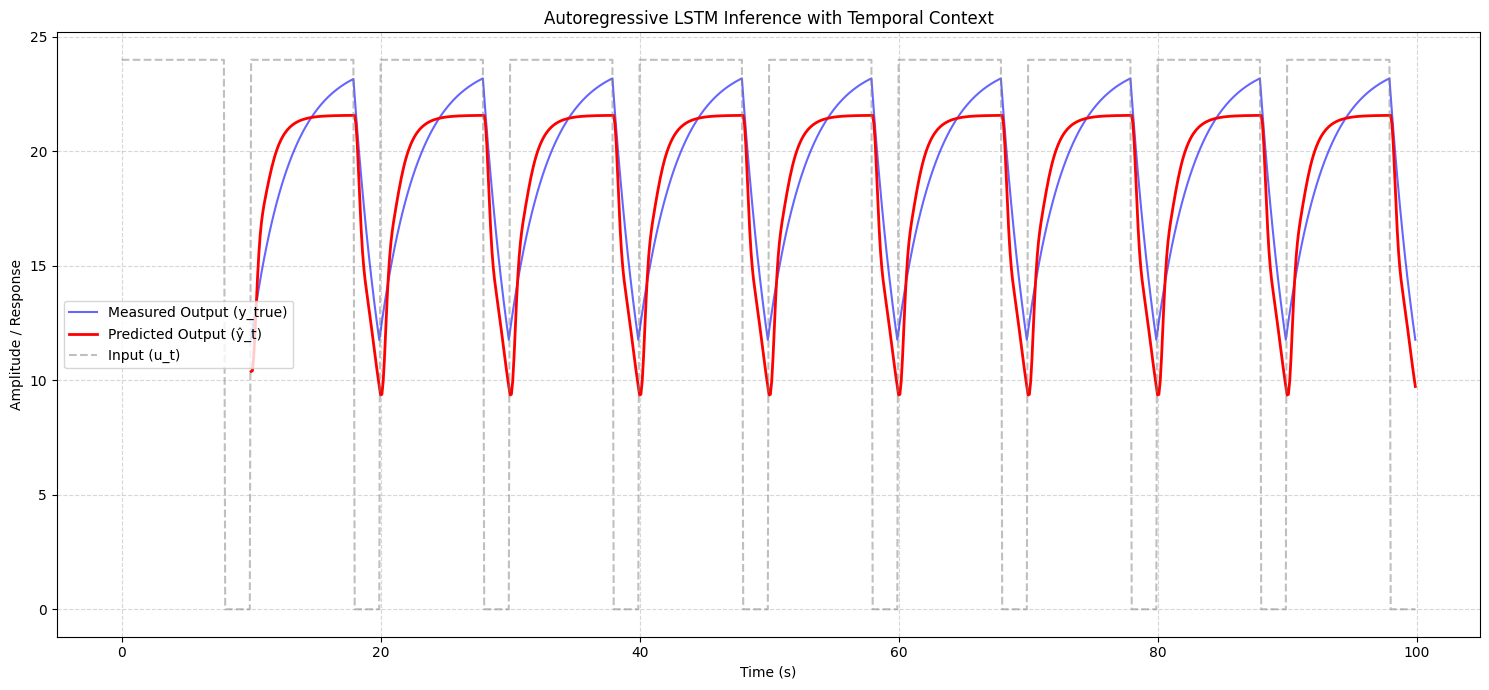


📊 Model Evaluation Results
--------------------------------------------------
📏 MSE  (Mean Squared Error):      2.258662
📏 RMSE (Root Mean Squared Error): 1.502885
📏 MAE  (Mean Absolute Error):     1.313243
📈 R²   (Coefficient of Determination): 0.801728
--------------------------------------------------


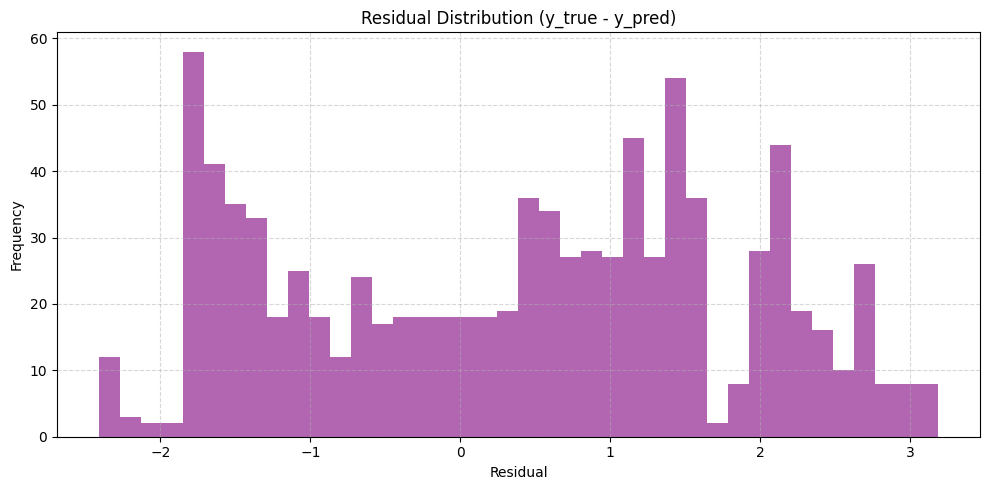

In [7]:
# ==============================================================
# LSTM Inference from Real CSV (Autoregressive Sequence Inference)
# (Enhanced version with auto scaler loading and feature matching)
# ==============================================================

%run setup_path.py
import pandas as pd
import torch
import numpy as np
import joblib
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from src.models.lstm_model import VanillaLSTM_MODEL, DeepLSTM_MODEL, BiLSTM_MODEL
from src.data.scaling_loader import ScalingZipLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================================================
# 1. Load model checkpoint
# ==============================================================
MODEL_PATH = Path(r"D:\Project_end\New_world\my_project\models\lstm_model_2_s.pth")
CSV_PATH = Path(r"D:\Project_end\New_world\my_project\data\raw\pwm_duty_0.80_freq_0.10_pwm_amplitude_1_freq_0.1_duty_0.8.csv")
SCALER_PATH = Path(r"D:\Project_end\New_world\my_project\config\Test1_scalers.zip")

checkpoint = torch.load(MODEL_PATH, map_location=torch.device("cpu"), weights_only=False)
print("✅ Loaded checkpoint from:", MODEL_PATH)

# ==============================================================
# 2. Extract model configuration
# ==============================================================
model_type = checkpoint.get("model_type", "DeepLSTM")
input_dim = checkpoint["input_dim"]
output_dim = checkpoint["output_dim"]
hidden_dim = checkpoint["hidden_dim"]
num_layers = checkpoint["num_layers"]
sequence_size = checkpoint.get("sequence_size", 50)
fc_units = checkpoint.get("fc_units", [64, 32])

print(f"🧠 Model Info:\n"
      f"   Type = {model_type}\n"
      f"   Input dim = {input_dim}, Hidden dim = {hidden_dim}, Output dim = {output_dim}\n"
      f"   Num layers = {num_layers}, Sequence size = {sequence_size}, FC units = {fc_units}")

# ==============================================================
# 3. Rebuild model
# ==============================================================
if model_type == "VanillaLSTM":
    model = VanillaLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "DeepLSTM":
    model = DeepLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
elif model_type == "BiLSTM":
    model = BiLSTM_MODEL(input_dim, hidden_dim, num_layers, output_dim, fc_units=fc_units)
else:
    raise ValueError(f"❌ Unknown model type: {model_type}")

model.load_state_dict(checkpoint["model_state_dict"], strict=False)
model.eval()
print("✅ Model ready for inference")

# ==============================================================
# 4. Load Scalers (Auto detect ZIP or PKL + Feature Alignment)
# ==============================================================
def load_scalers_auto(path: Path):
    if str(path).endswith(".zip"):
        print("📦 Detected ZIP scaler → using ScalingZipLoader")
        loader = ScalingZipLoader(path)
        scaler_x, scaler_y = loader.scaler_in, loader.scaler_out
        input_features = getattr(loader, "input_features", ["DATA_INPUT", "DATA_OUTPUT"])
        output_features = getattr(loader, "output_features", ["DATA_OUTPUT"])
    elif str(path).endswith(".pkl"):
        print("📦 Detected PKL scaler → using joblib.load()")
        data = joblib.load(path)
        scaler_x = data.get("input_scaler", data.get("scaler_in"))
        scaler_y = data.get("output_scaler", data.get("scaler_out"))
        input_features = data.get("input_features", ["DATA_INPUT", "DATA_OUTPUT"])
        output_features = data.get("output_features", ["DATA_OUTPUT"])
    else:
        raise ValueError("❌ Unsupported scaler format. Must be .zip or .pkl")
    return scaler_x, scaler_y, input_features, output_features

scaler_x, scaler_y, input_features, output_features = load_scalers_auto(SCALER_PATH)
print("✅ Loaded scalers successfully with features:", input_features)

# ==============================================================
# 5. Load CSV signal data
# ==============================================================
df = pd.read_csv(CSV_PATH)
if not any("INPUT" in c.upper() for c in df.columns):
    raise KeyError("❌ CSV must contain at least one input column (e.g., 'DATA_INPUT')")

input_col = [c for c in df.columns if "INPUT" in c.upper()][0]
output_col = [c for c in df.columns if "OUTPUT" in c.upper()][0]

u_signal = df[input_col].values
y_true = df[output_col].values
t = np.arange(len(u_signal)) * 0.1

# ==============================================================
# 6. Autoregressive Inference (Auto Feature Matching)
# ==============================================================
seq_len = sequence_size
y_preds = []
buffer_y = list(y_true[:seq_len])
buffer_u = list(u_signal[:seq_len])

for i in range(seq_len, len(u_signal)):
    seq_data = []
    for name in input_features:
        if "INPUT" in name.upper():
            seq_data.append(buffer_u[-seq_len:])
        elif "OUTPUT" in name.upper() or "Y" in name.upper():
            seq_data.append(buffer_y[-seq_len:])
        else:
            seq_data.append(np.zeros(seq_len))  # unknown features = 0

    seq_input = pd.DataFrame(np.column_stack(seq_data), columns=input_features)

    # --- Apply scaler transformation ---
    try:
        x_scaled = scaler_x.transform(seq_input)
    except Exception as e:
        print("⚠️ Fallback: using partial columns match")
        valid_cols = [c for c in seq_input.columns if c in getattr(scaler_x, "feature_names_in_", seq_input.columns)]
        x_scaled = scaler_x.transform(seq_input[valid_cols])

    # --- Predict ---
    x_tensor = torch.tensor(x_scaled[np.newaxis, :, :], dtype=torch.float32)
    if x_tensor.shape[-1] != input_dim:
        # Auto-fix dimension mismatch by trimming or padding
        diff = input_dim - x_tensor.shape[-1]
        if diff > 0:
            pad = torch.zeros((1, seq_len, diff))
            x_tensor = torch.cat([x_tensor, pad], dim=-1)
        elif diff < 0:
            x_tensor = x_tensor[:, :, :input_dim]
        #print(f"⚙️ Auto adjusted input dim to {x_tensor.shape[-1]} (expected {input_dim})")

    with torch.no_grad():
        y_scaled = model(x_tensor)
        y_next = scaler_y.inverse_transform(y_scaled.numpy())[0, 0]

    y_preds.append(y_next)
    buffer_y.append(y_next)
    buffer_u.append(u_signal[i])

y_preds = np.array(y_preds)
y_true_eval = y_true[seq_len:]
t_eval = t[seq_len:]

# ==============================================================
# 7. Visualization
# ==============================================================
plt.figure(figsize=(15, 7))
plt.plot(t_eval, y_true_eval, label="Measured Output (y_true)", color="blue", alpha=0.6)
plt.plot(t_eval, y_preds, label="Predicted Output (ŷ_t)", color="red", linewidth=2)
plt.plot(t, u_signal, label="Input (u_t)", color="gray", linestyle="--", alpha=0.5)
plt.title("Autoregressive LSTM Inference with Temporal Context")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / Response")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# ==============================================================
# 8. Evaluation Metrics
# ==============================================================
mse = mean_squared_error(y_true_eval, y_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true_eval, y_preds)
r2 = r2_score(y_true_eval, y_preds)

print("\n📊 Model Evaluation Results")
print("--------------------------------------------------")
print(f"📏 MSE  (Mean Squared Error):      {mse:.6f}")
print(f"📏 RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"📏 MAE  (Mean Absolute Error):     {mae:.6f}")
print(f"📈 R²   (Coefficient of Determination): {r2:.6f}")
print("--------------------------------------------------")

# Residuals
residuals = y_true_eval - y_preds
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=40, color="purple", alpha=0.6)
plt.title("Residual Distribution (y_true - y_pred)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import torch
import pandas as pd

class LSTMEnvironment:
    """
    Environment simulator that uses a pre-trained LSTM model
    to simulate system dynamics (Model-based Environment for RL).
    """

    def __init__(self, model, scaler_x, scaler_y, input_features, output_features,
                 seq_len=50, target=None):
        self.model = model.eval()
        self.scaler_x = scaler_x
        self.scaler_y = scaler_y
        self.input_features = input_features
        self.output_features = output_features
        self.seq_len = seq_len

        # Buffers for autoregressive context
        self.buffer_u = []
        self.buffer_y = []

        # Target for reward calculation (optional)
        self.target = target if target is not None else 1.0  # desired output value

    def reset(self, init_input=0.0, init_output=0.0):
        """Reset buffers to initial state."""
        self.buffer_u = [init_input] * self.seq_len
        self.buffer_y = [init_output] * self.seq_len
        state = np.array(self.buffer_y[-self.seq_len:], dtype=np.float32)
        return state

    def step(self, action):
        """
        Take an action (e.g., control signal), predict next output with LSTM,
        compute reward, and return (state_next, reward, done, info)
        """
        # Append new action to input buffer
        self.buffer_u.append(action)

        # Build sequence dataframe
        seq_data = []
        for name in self.input_features:
            if "INPUT" in name.upper():
                seq_data.append(self.buffer_u[-self.seq_len:])
            elif "OUTPUT" in name.upper():
                seq_data.append(self.buffer_y[-self.seq_len:])
            else:
                seq_data.append(np.zeros(self.seq_len))
        seq_df = pd.DataFrame(np.column_stack(seq_data), columns=self.input_features)

        # Scale input
        x_scaled = self.scaler_x.transform(seq_df)
        x_tensor = torch.tensor(x_scaled[np.newaxis, :, :], dtype=torch.float32)

        # Predict next output
        with torch.no_grad():
            y_scaled = self.model(x_tensor)
            y_next = self.scaler_y.inverse_transform(y_scaled.numpy())[0, 0]

        # Update output buffer
        self.buffer_y.append(y_next)

        # Define reward (example: negative error to target)
        error = abs(self.target - y_next)
        reward = -error  # reward higher when closer to target

        # Define new state as last sequence of outputs
        state_next = np.array(self.buffer_y[-self.seq_len:], dtype=np.float32)

        done = False  # or condition like too large error
        info = {"y_next": y_next, "error": error}

        return state_next, reward, done, info


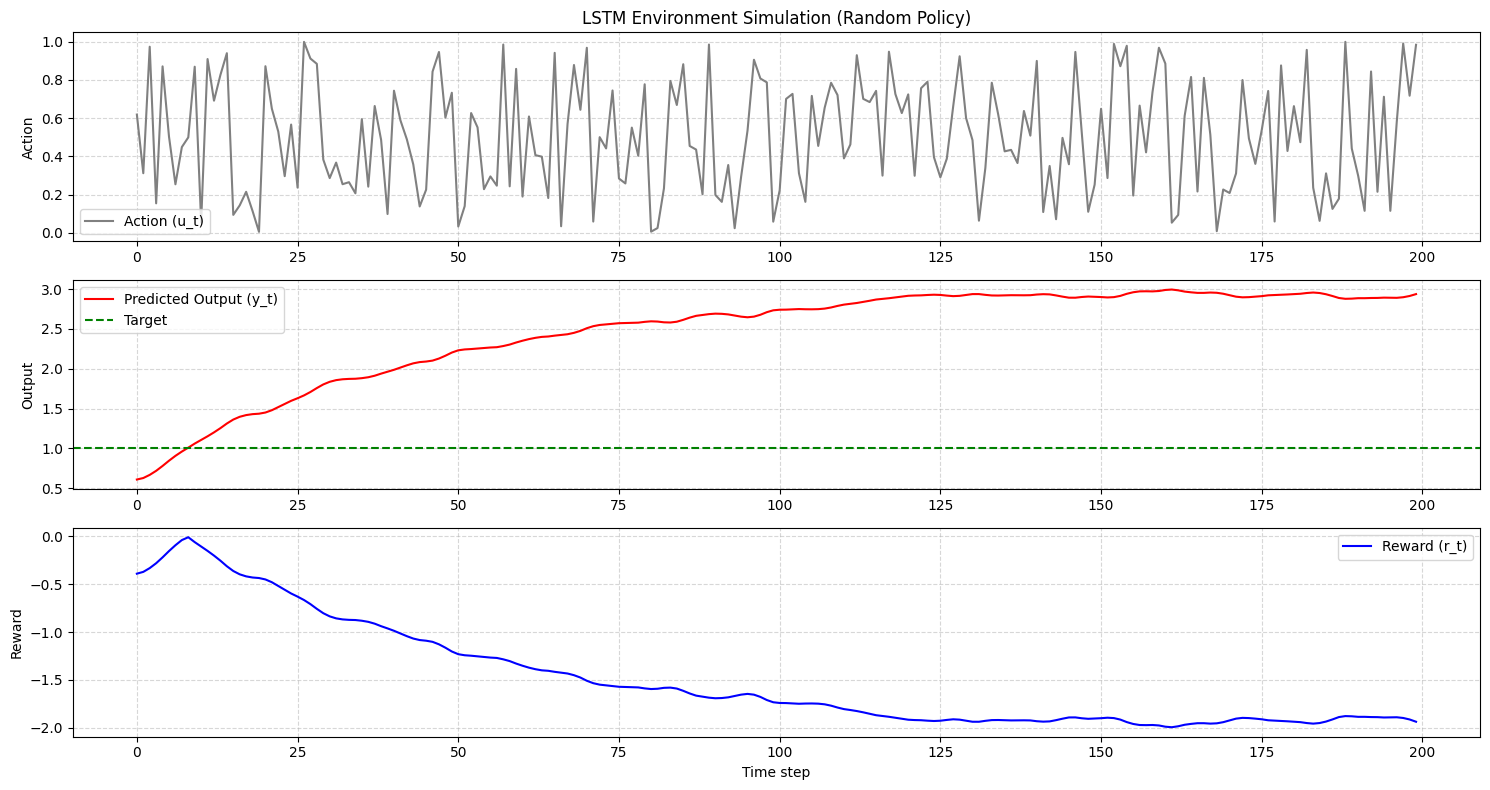

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================
# Initialize environment
# ==============================================================
env = LSTMEnvironment(
    model=model,
    scaler_x=scaler_x,
    scaler_y=scaler_y,
    input_features=input_features,
    output_features=output_features,
    seq_len=sequence_size,
    target=1.0
)

# ==============================================================
# Reset environment
# ==============================================================
state = env.reset(init_input=0.0, init_output=0.0)

# ==============================================================
# RL Simulation Loop (Random Policy Example)
# ==============================================================
n_steps = 200  # จำนวน timestep ที่จำลอง
actions, outputs, rewards = [], [], []

for step in range(n_steps):
    # ตัวอย่าง: สุ่ม action จาก 0–1 (แทนการควบคุมจาก agent จริง)
    action = np.random.uniform(0, 1)
    
    next_state, reward, done, info = env.step(action)

    # เก็บค่าต่าง ๆ สำหรับวิเคราะห์ภายหลัง
    actions.append(action)
    outputs.append(info["y_next"])
    rewards.append(reward)

    if done:
        break

# ==============================================================
# Visualization
# ==============================================================
t = np.arange(len(actions))

plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(t, actions, color="gray", label="Action (u_t)")
plt.ylabel("Action")
plt.title("LSTM Environment Simulation (Random Policy)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, outputs, color="red", label="Predicted Output (y_t)")
plt.axhline(env.target, color="green", linestyle="--", label="Target")
plt.ylabel("Output")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, rewards, color="blue", label="Reward (r_t)")
plt.xlabel("Time step")
plt.ylabel("Reward")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
